In [301]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)   
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [302]:
with open("data/Data_120294_2023-03-29.csv", "r") as f:
    d = pd.read_csv(f)

d.head()

/tmp/ipykernel_103143/2003393883.py:2: DtypeWarning: Columns (2,64,91,94,97,106,108,109,110,111,112,114,116,119,120,122,127,139,142,143,144,145,152,153,154,155,156,157,159,160,161,163,164,165,169,170,171,172,175,178,179,180,187,189,215,216,217,218,219,317,318) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(f)


,wl_org,cod_wl,cod_ostxt_wl,num_prev_tx,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,bmi_tcr,education,ecmo_tcr,iabp_tcr,inhaled_no,inotropes_tcr,vad_device_ty_tcr,vad_brand1_tcr,vad_brand2_tcr,vad_tah_tcr,func_stat_tcr,tcr_dgn,diab,dial_ty_tcr,cereb_vasc,malig_tcr,malig_ty_tcr,most_rcnt_creat,tot_serum_album,sud_death,impl_defibril,hemo_sys_tcr,hemo_pa_dia_tcr,hemo_pa_mn_tcr,hemo_pcw_tcr,hemo_co_tcr,cig_use,tcr_dur_abstain,prior_card_surg_tcr,histry_cig_old,sternotomy_tcr,ssdmf_death_date,days_stat1,days_stat1a,days_stat2,days_stat1b,days_stata4,days_stata5,days_stata2,days_stata3,days_stata1,days_stata6,init_stat,init_creat,rem_cd,dayswait_chron,end_stat,init_age,life_sup_tcr,activate_date,death_date,end_date,init_date,ethnicity,ethcat,pt_code,init_hgt_cm_calc,init_wgt_kg_calc,init_bmi_calc,end_hgt_cm_calc,end_wgt_kg_calc,end_bmi_calc,composite_death_date,ventilator_tcr,lvad_at_listing,lvad_while_listed,rvad_at_listing,rvad_while_listed,work_income_tcr,academic_prg_tcr,academic_level_tcr,exercise_o2,academic_level_trr,academic_prg_trr,func_stat_trr,med_cond_trr,ecmo_trr,work_income_trr,cognitive_dev_trr,motor_dev_trr,measurement_date_trr,pge_trr,creat_trr,dial_after_list,fev1_trr,fvc_trr,hemo_co_trr,hemo_pa_dia_trr,hemo_pa_mn_trr,hemo_pcw_trr,hemo_sys_trr,iabp_trr,infect_iv_drug_trr,inotropes_trr,inotrop_vaso_co_trr,inotrop_vaso_dia_trr,inotrop_vaso_mn_trr,inotrop_vaso_pcw_trr,inotrop_vaso_sys_trr,pco2_trr,steroid,tbili,transfusions,vad_device_ty_trr,prior_card_surg_type_trr,prior_card_surg_type_ostxt_trr,cmv_status,cod,cod_ostxt,gstatus,gtime,lastfuno,ptime,px_stat,func_stat_trf,amis,bmis,drmis,hlamis,pramr,prapk,pramr_cl1,pramr_cl2,prapk_cl1,prapk_cl2,hist_cocaine_don,age_don,ethcat_don,abo_don,alcohol_heavy_don,gender_don,cod_ostxt_don,bun_don,creat_don,sgot_don,sgpt_don,tbili_don,hypertens_dur_don,cancer_oth_ostxt_don,contin_cig_don,contin_cocaine_don,contin_oth_drug_don,diet_don,diuretics_don,diabdur_don,hist_hypertens_don,hist_cancer_don,hist_insulin_dep_don,hist_diabetes_don,diabetes_don,hist_oth_drug_don,insulin_don,hgt_cm_don_calc,wgt_kg_don_calc,bmi_don_calc,px_stat_date,tx_date,discharge_date,tx_type,abo_mat,age,dial_prior_tx,ischtime,grf_fail_cause,grf_fail_date,grf_stat,age_group,hgt_cm_calc,wgt_kg_calc,bmi_calc,distance,vad_tah_trr,tx_year,referral_date,pco2_don,pulm_cath_don,map_init_don,map_post_don,cvp_cath_init_don,cvp_cath_post_don,cvp_cath_old_don,pcwp_init_don,pcwp_post_don,svr_init_don,svr_post_don,syst_pa_cath_init_don,syst_pa_cath_post_don,systolic_pa_cath_old_don,diast_pa_cath_init_don,diast_pa_cath_post_don,diastolic_pa_cath_old_don,cardiac_output_cath_init_don,cardiac_output_cath_post_don,cardiac_output_cath_old_don,card_idx_init_don,card_idx_post_don,broncho_lt_don,broncho_rt_don,chest_xray_don,ph_don,hematocrit_don,abn_valves_don,abn_lvh_don,abn_congen_don,wall_abn_seg_don,wall_abn_glob_don,data_transplant,data_waitlist,alg_ind,alg_maint,cyclosporin_ind,cyclosporin_maint,okt4_ind,okt4_maint,cytoxan_ind,cytoxan_maint,methotrexate_ind,methotrexate_maint,brequinarsodium_ind,brequinarsodium_maint,mizoribine_ind,mizoribine_maint,atgam_ind,atgam_maint,nratgnrats_ind,nratgnrats_maint,okt3_ind,okt3_maint,xomazymecd5_ind,xomazymecd5_maint,dab486il2_ind,dab486il2_maint,antilfa1_ind,antilfa1_maint,antiicam1_ind,antiicam1_maint,il1receptorantagonist_ind,il1receptorantagonist_maint,antiil6_ind,antiil6_maint,antitnf_ind,antitnf_maint,solubleil1receptor_ind,solubleil1receptor_maint,aldesleukin_ind,aldesleukin_maint,t10b9_ind,t10b9_maint,sandimmune_ind,sandimmune_maint,deoxyspergualin_ind,deoxyspergualin_maint,neoral_ind,neoral_maint,sangcya_ind,sangcya_maint,thymoglobulin_ind,thymoglobulin_maint,zenapax_ind,zenapax_maint,simulect_ind,simulect_maint,gengraf_ind,gengraf_maint,zortress_ind,zortress_maint,eon_ind,eon_maint,myfortic_ind,myfortic_maint,genericcyclosporin_ind,genericcyclosporin_maint,steroids_ind,steroids_maint,prograf_ind,prograf_maint,campath_ind,campath_maint,fty720_in

# Column categorization

In [303]:
print(d.education.dtype)
print(d.education.unique())

float64
[ nan   6.   5.   4.   3.   2. 996. 998.   1.]


There seems to exists columns that appear numeric but are actually categoric. We need to categorize all columns into numeric or categoric values in able to normalize and impute values properly.

In the provided documentation XLS file, numeric columns do not have a "SAS ANALYSIS FORMAT". The "SAS FORMAT" columns also gives information about how the data is formatted. Specially, some data is formatted as dates and datetimes, and need to be handled separately. Let's use this information to categorize the columns.

In [304]:
# fetch data from excel file
with open("data/Documentation.xls", "rb") as f:
    docs = pd.read_excel(f, sheet_name=None, header=None)
docs[list(docs.keys())[0]].head()

,0,1,2
0,Worksheet Tab Name,Description of Contents,Relative File (s)
1,File Formats,Explanation of the data file formats within folders provided on the disc,ALL
2,MAIN DOCUMENTATION,Descriptions for individual files with hyperlinks to data field documentation,ALL
3,Formats (Lookup Values),Provides locations for SAS formats and lookup values for variables,ALL
4,Additional HLA,Data dictionary for HLA data (all organ types),All Organs


In [305]:
def is_data_sheet(docs, sheet):
    if "SAS ANALYSIS FORMAT" in docs[sheet].values[1] \
    and "FORMAT".lower() not in sheet.lower():
        return True
    return False

def find_column_index(docs, sheet, column_name):
    return list(docs[sheet].values[1]).index(column_name)

discovered_columns = set()
numerical_columns = set()
categorical_columns = set()
date_columns = set()
text_columns = set()
drug_columns = set()
unknown_type_columns = set()

for sheet in docs:
    if is_data_sheet(docs, sheet):
        sas_index = find_column_index(docs, sheet, "SAS ANALYSIS FORMAT")
        format_index = find_column_index(docs, sheet, "SAS FORMAT")
        type_index = find_column_index(docs, sheet, "DATA TYPE")

        for row in docs[sheet].values[2:]:
            cname = row[0].lower()
            if cname not in discovered_columns:
                discovered_columns.add(cname)

                csas = str(row[sas_index]).upper()
                ctype = str(row[type_index]).upper()
                cformat = str(row[format_index]).upper()

                if "ostxt" in cname:
                    text_columns.add(cname)
                elif cname.endswith("_ind") or cname.endswith("_maint"):
                    drug_columns.add(cname)
                elif ctype == "NUM":
                    if "MMDDYY" in cformat or "MMDDYY" in csas:
                        date_columns.add(cname)
                    elif csas == "NAN":
                        numerical_columns.add(cname)
                    else:
                        categorical_columns.add(cname)
                elif ctype == "CHAR":
                    categorical_columns.add(cname)
                elif ctype == "DATE":
                    date_columns.add(cname)
                else:
                    unknown_type_columns.add(cname)


print("Numerical columns:", numerical_columns)
print("Categorical columns:", categorical_columns)
print("Date columns", date_columns)
print("String columns:", text_columns)
print("Unknown type columns:", unknown_type_columns)

Numerical columns: {'orig_tumor_size3', 'val_dt_malig', 'tumor_size2', 'num_ki_disc', 'org_ty_doudenum', 'days_stata5', 'cont_iv_inotropes', 'num_hosp', 'ino_procure_dose_dur_3', 'calc_pa_systolic', 'ecd_donor', 'mcsdinfectiondebridement', 'skin_melanoma_donor', 'totisch', 'init_current_pra', 'doncrit_peak_creat_import', 'iab_pump', 'inosysbloodpressuredt', 'max_expanded_mismatch_dr', 'chd', 'ejfrac', 'warm_isch_tm_left', 'pge_tcr', 'systolic_pressure', 'changedate', 'max_expanded_mismatch_a', 'on_expand_donor', 'alkphos', 'doncrit_min_hgt_import', 'low_pco2_ph', 'oth_life_sup_tcr', 'r_fin_resist_tx', 'gstatus', 'init_epts', 'frac_spine', 'pretiterb', 'other_inf_don', 'contrast3', 'cold_isch_tm_left', 'extcardiacindexdt', 'malig_don_rel_29_dx_date', 'hemohemoglobin', 'tcr_cdc_growth_hgt', 'preop_pao2', 'doncrit_peak_creat', 'arginine_begin_dt', 'hemodt', 'method_blood_sugar_control_pa', 'malig_don_rel_8_dx_date', 'hemomeanpressurest', 'mcsdwithrhfvenpressuredt', 'washout6', 'mcsdwithpu

Let's investigate the columns with unknown type.

In [306]:
for column in unknown_type_columns:
    if column in d.columns:
        print(column, d[column].dtype, d[column].unique())

None of these columns are in the dataset, so we are going to ignore them.

Let's explore how well the documentation describes the data set.

In [307]:

col_union = set.union(numerical_columns, categorical_columns, date_columns, text_columns, unknown_type_columns)
print("Number columns in the documentation:", len(col_union))

print("Number columns in dataset:", len(d.columns))

intersect = col_union & set(d.columns)
print("Number shared columns:", len(intersect))

# check which columns are not described in the documentation
non_described_columns = set(d.columns) - intersect
print("Number undocumented:", len(non_described_columns))
print("Undocumented columns:", non_described_columns)


Number columns in the documentation: 2763
Number columns in dataset: 320
Number shared columns: 222
Number undocumented: 98
Undocumented columns: {'antiicam1_ind', 'aldesleukin_maint', 'myfortic_ind', 'oth_drug_ind2', 'genericcyclosporin_maint', 'okt4_ind', 'prograf_maint', 'rapamune_ind', 'dab486il2_maint', 'envarsusxr_maint', 'solubleil1receptor_ind', 'antilfa1_ind', 'alg_ind', 'dab486il2_ind', 'genericcyclosporin_ind', 'aldesleukin_ind', 'myfortic_maint', 'neoral_ind', 'rituxan_ind', 'brequinarsodium_maint', 'eon_maint', 'simulect_maint', 'xomazymecd5_maint', 'deoxyspergualin_ind', 'alg_maint', 'cytoxan_ind', 'rapamune_maint', 'antiil6_maint', 'oth_drug_ind1', 'nulojix_maint', 'prograf_ind', 't10b9_maint', 'okt4_maint', 'methotrexate_maint', 'steroids_maint', 'genericmyfortic_maint', 'neoral_maint', 'cellcept_maint', 'solubleil1receptor_maint', 'antiicam1_maint', 'envarsusxr_ind', 'generictacrolimus_maint', 'leflunomide_ind', 'brequinarsodium_ind', 'antilfa1_maint', 'cyclosporin_ind

Let's investigate the types of these columns.

In [308]:
for col in non_described_columns:
    # print unique values and counts of each column
    print(d[col].value_counts())

1.00000    7
0.00000    2
Name: antiicam1_ind, dtype: int64
0.00000    15
Name: aldesleukin_maint, dtype: int64
0.00000    2028
1.00000       1
Name: myfortic_ind, dtype: int64
0.00000    181
1.00000    159
Name: oth_drug_ind2, dtype: int64
1.00000    256
0.00000      1
Name: genericcyclosporin_maint, dtype: int64
1.00000    8
0.00000    6
Name: okt4_ind, dtype: int64
1.00000    26215
0.00000      110
Name: prograf_maint, dtype: int64
0.00000    983
1.00000    134
Name: rapamune_ind, dtype: int64
0.00000    10
1.00000     2
Name: dab486il2_maint, dtype: int64
1.00000    88
Name: envarsusxr_maint, dtype: int64
0.00000    7
Name: solubleil1receptor_ind, dtype: int64
0.00000    6
Name: antilfa1_ind, dtype: int64
0.00000    20
1.00000    19
Name: alg_ind, dtype: int64
1.00000    10
0.00000     2
Name: dab486il2_ind, dtype: int64
0.00000    255
1.00000      2
Name: genericcyclosporin_ind, dtype: int64
0.00000    15
Name: aldesleukin_ind, dtype: int64
1.00000    2027
0.00000       2
Name: my

Most of these columns are drug related or categorical. Let's categorize these similarly to before.

In [309]:
for col in non_described_columns:
    if col.endswith("_ind") or col.endswith("_maint"):
        drug_columns.add(col)
    elif "ostxt" in col:
        text_columns.add(col)
    else:
        categorical_columns.add(col)
unknown_type_columns = []

Let's investigate if any categoric columns have too many unique values.

In [310]:
# sort columns by number of unique values
categoric_sorted_unique = d[list(categorical_columns & set(d.columns))].nunique().sort_values(ascending=False)
print(categoric_sorted_unique)

cod                         76
cod_wl                      63
malig_ty_tcr                56
thoracic_dgn                56
tcr_dgn                     42
prior_card_surg_type_trr    27
func_stat_trr               25
func_stat_trf               25
func_stat_tcr               25
rem_cd                      18
init_stat                   11
end_stat                    11
abo                          9
abo_don                      9
tcr_dur_abstain              9
vad_tah_trr                  8
ethcat_don                   8
broncho_lt_don               8
education                    8
broncho_rt_don               8
vad_tah_tcr                  8
ethcat                       8
chest_xray_don               7
vad_device_ty_trr            6
vad_device_ty_tcr            6
diab                         6
hist_diabetes_don            6
academic_level_trr           6
academic_level_tcr           5
academic_prg_trr             5
motor_dev_trr                5
dial_ty_tcr                  5
academic

Let's similarly investigate if any numeric columns have too few unique values.

In [311]:
numeric_sorted_unique = d[list(numerical_columns & set(d.columns))].nunique().sort_values(ascending=True)
print(numeric_sorted_unique)

init_creat                           0
pco2_trr                             1
lvad_at_listing                      1
rvad_while_listed                    1
rvad_at_listing                      1
lvad_while_listed                    1
iabp_trr                             2
ecmo_trr                             2
ecmo_tcr                             2
inotropes_trr                        2
pge_trr                              2
fvc_trr                              2
iabp_tcr                             2
inotropes_tcr                        2
fev1_trr                             2
inhaled_no                           2
gstatus                              2
ventilator_tcr                       2
bmis                                 3
amis                                 3
drmis                                3
sternotomy_tcr                       4
exercise_o2                          4
hlamis                               7
num_prev_tx                         10
vad_brand2_tcr           

Consulting with the documentation descriptions, some of these columns were misidentified, and should be categorical.

In [312]:
misidentified_columns = set([
    'init_creat',
    'lvad_at_listing',
    'lvad_while_listed',
    'rvad_at_listing',
    'rvad_while_listed',
    'iabp_tcr',
    'iabp_trr',
    'ecmo_tcr',
    'ecmo_trr',
    'inotropes_tcr',
    'inotropes_trr',
    'inhaled_no',
    'gstatus',
    'pge_trr',
    'ventilator_tcr',
    'amis',
    'bmis',
    'drmis',
    'vad_brand1_tcr',
    'vad_brand2_tcr'
])

#exercise_o2?

categorical_columns = categorical_columns | misidentified_columns
numerical_columns = numerical_columns - misidentified_columns

Let's exclude variables not in the dataset.

In [313]:
numerical_columns = list(numerical_columns & set(d.columns))
categorical_columns = list(categorical_columns & set(d.columns))
date_columns = list(date_columns & set(d.columns))
drug_columns = list(drug_columns & set(d.columns))
text_columns = list(text_columns & set(d.columns))

In [314]:
print("Columns in the dataset:\n")
print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))
print("Number text columns:", len(text_columns))

Columns in the dataset:

Number numeric columns: 91
Number categorical columns: 119
Number date columns: 12
Number drug columns: 91
Number text columns: 7


That's all the categorization done.

Let's additionally convert the date columns to comparable timestamps.

In [315]:
for col in date_columns:
    d[col] = pd.to_datetime(d[col], format="%d%b%Y")

# Removal of unwanted data

We want to remove all data of people under the age of 18.

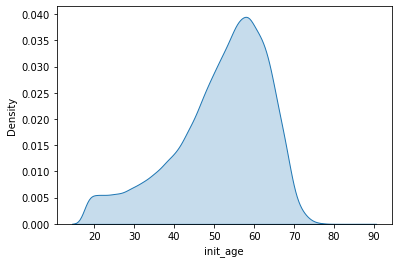

In [316]:
d = d[d.init_age >= 18]

# plot distribution of age
sns.kdeplot(d.init_age, fill=True)
plt.show()

Furthermore, we need to somehow merge entries belonging to the same patient.

One way to handle this is to just drop all rows of patients with more than one record in the waitlist. However, this might be a bit crude if there are many patients with multiple records.

Proportion of patients with more than one record: 0.07628644895324749
0    12314
1     2917
2       84
3       13
Name: num_prev_tx, dtype: int64
0     87734
1       925
2        53
3         8
5         3
6         2
10        2
4         2
9         1
7         1
Name: num_prev_tx, dtype: int64


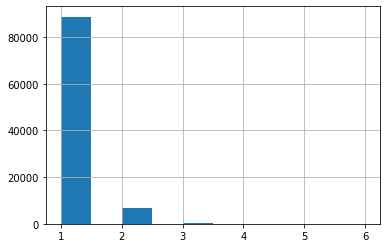

In [317]:
rcount = d.groupby("pt_code").wl_org.count()
rcount.hist()

gt1 = rcount[rcount > 1]

# print proportion of patients with at least 2 records
print("Proportion of patients with more than one record:", len(gt1) / d.pt_code.nunique())

# of those with more than one record, print the value counts for "num_prev_tx"
print(d[d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())
# num_prev_tx for those with only one record
print(d[~d.pt_code.isin(gt1.index)].num_prev_tx.value_counts())

There are a significant amount of patients with multiple records, but by experimentation, keeping one record of each patients or removing them all patients with multiple records produced very similar results.

For now, we will remove all patients with duplicate entries.

In [318]:
d.sort_values(by=['pt_code', 'num_prev_tx', 'init_date'], inplace=True)
#d.drop_duplicates(subset=['pt_code', 'num_prev_tx'], keep='last', inplace=True)

# Remove all patients with multiple records
d.drop_duplicates(subset=['pt_code'], keep=False, inplace=True)

There is a large amount of possible outcomes for each patient, detailed in the column rem_cd. Most of these outcomes have barely any patients assigned to them. We will filter the data set to only include the most common outcomes.

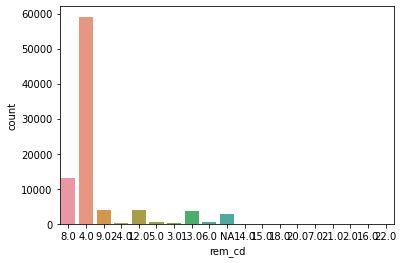

In [319]:
sns.countplot(x="rem_cd", data=d.fillna("NA"))
plt.show()

Let's remove all outcomes except transplant and death.

In [320]:
d = d[d.rem_cd.isin([4,8,13])]

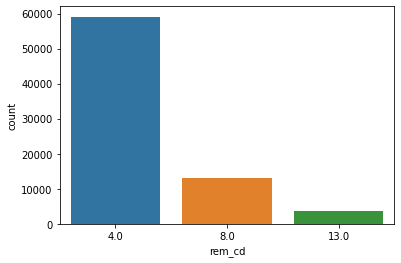

In [321]:
sns.countplot(x="rem_cd", data=d.fillna("NA"))
plt.show()

# Removal of outliers

Before imputation and normalization, outliers need to be removed.

We're not interested in any patients that have a negative waitlist time.

In [322]:
neg = d[d.end_date < d.init_date]
print("Numer of negative wait times:", len(neg))
d.drop(neg.index, inplace=True)

Numer of negative wait times: 4


Extreme outliers will be removed based on quantile.

In [323]:
# replace outliers of numerical columns with NaN
lower = d.quantile(0.0005, numeric_only=True)
upper = d.quantile(0.9995, numeric_only=True)
d2 = d.copy()

d2[numerical_columns] = d2[numerical_columns][(d2[numerical_columns].lt(upper)) & (d2[numerical_columns].gt(lower))]
d, d2 = d2, d

Here's an example of how removing outliers improves the usability of values. This is the distribution plot of the column "bmi_tcr" before and after removing outliers.

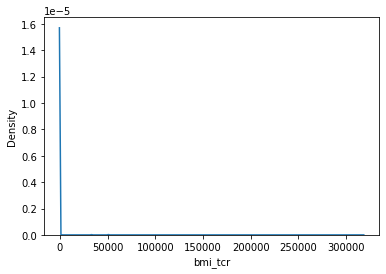

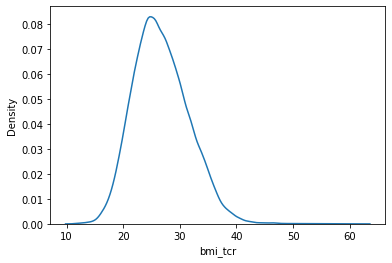

In [324]:
col = "bmi_tcr"

sns.kdeplot(d2[col].dropna())
plt.show()

sns.kdeplot(d[col].dropna())
plt.show()


# Selection of candidate columns

Variables are selected as deemed approprate by one of our supervisors.

In [325]:
sheet = pd.read_excel("data/VariableNames_v3.xlsx", sheet_name="Sheet1")
inclusion = dict(zip(sheet.iloc[:, 0], sheet.iloc[:, 2]))

selected_vars = [var for var in inclusion if inclusion[var] == "X"]
selected_vars.remove("init_creat") # only contains missing values

print("Selected variables:", selected_vars)
print("Number variables:", len(selected_vars))

Selected variables: ['thoracic_dgn', 'tah', 'vas', 'onvent', 'icu', 'inotropic', 'gender', 'abo', 'wgt_kg_tcr', 'hgt_cm_tcr', 'education', 'ecmo_tcr', 'iabp_tcr', 'inotropes_tcr', 'func_stat_tcr', 'diab', 'dial_ty_tcr', 'cereb_vasc', 'malig_tcr', 'most_rcnt_creat', 'tot_serum_album', 'hemo_co_tcr', 'cig_use', 'prior_card_surg_tcr', 'init_stat', 'init_age', 'ethnicity', 'init_hgt_cm_calc', 'init_wgt_kg_calc', 'ventilator_tcr', 'lvad_at_listing', 'rvad_at_listing', 'work_income_tcr', 'academic_level_tcr']
Number variables: 34


Let's prepare a time to death variable to categorize death outcomes in different time periods.

To accomplish this, we need to determine which columns will help us determine time to death.

In [326]:
d["total_wl_time"] = (d.end_date - d.init_date).dt.days

print(f"%missing values in total_wl_time: {d.total_wl_time.isna().sum() / len(d) * 100:.2f}%")
print(f"%missing values in dayswait_chron: {d.dayswait_chron.isna().sum() / len(d) * 100:.2f}%")

# for non missing rows of dayswait_chron, check if total_wl_time is equal to dayswait_chron
print(f"%rows where total_wl_time is equal to dayswait_chron: {(d[d.dayswait_chron.notna()].total_wl_time == d[d.dayswait_chron.notna()].dayswait_chron).sum() / len(d) * 100:.2f}%")

%missing values in total_wl_time: 0.00%
%missing values in dayswait_chron: 0.35%
%rows where total_wl_time is equal to dayswait_chron: 99.65%


Given the similarity between dayswait_chron and the calculated column total_wl_time, and the fact that total_wl_time has no missing values, dayswait_chron is useless.

There is also a column, composite_death_date, that has the least missing values of death related columns. We can use this to calculate a time_to_death variable.

count   43621.00000
mean     2107.88540
std      2302.22015
min         0.00000
25%       192.00000
50%      1172.00000
75%      3525.00000
max     11771.00000
%NA          42.50%
Name: time_to_death, dtype: object


<AxesSubplot: >

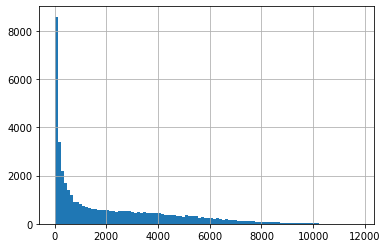

In [327]:
d["time_to_death"] = (d.composite_death_date - d.init_date).dt.days
desc = d.time_to_death.describe()
desc["%NA"] = f"{d.time_to_death.isna().sum() / len(d) * 100:.2f}%"
print(desc)
d.time_to_death.hist(bins=100)

We see a lot of NA values, but not as much for actual death outcomes:

In [328]:
desc = d[d.rem_cd.isin([8, 13])].time_to_death.describe()
desc["%NaN"] = f"{d[d.rem_cd.isin([8, 13])].time_to_death.isna().sum() / len(d[d.rem_cd.isin([8, 13])]) * 100:.2f}%"
print(desc)

count   13492.00000
mean      427.18581
std       712.04274
min         0.00000
25%        32.00000
50%       136.00000
75%       505.00000
max      7910.00000
%NaN         19.60%
Name: time_to_death, dtype: object


Let's compare the usability of time_to_death and total_wl_time.

<AxesSubplot: >

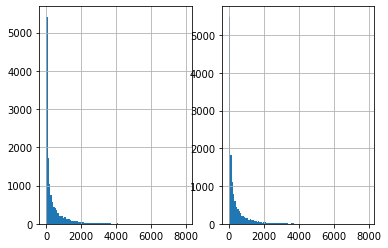

In [329]:
plt.subplot(1, 2, 1)
d[d.time_to_death.notna() & d.rem_cd.isin([8,13])].time_to_death.hist(bins=100)
plt.subplot(1, 2, 2)
d[d.time_to_death.notna() & d.rem_cd.isin([8,13])].total_wl_time.hist(bins=100)

In [330]:
desc = d[d.rem_cd.isin([8, 13])].total_wl_time.describe()
desc["%NaN"] = f"{d[d.rem_cd.isin([8, 13])].total_wl_time.isna().sum() / len(d[d.rem_cd.isin([8, 13])]) * 100:.2f}%"
print(desc)

count   16781.00000
mean      359.89542
std       612.00411
min         0.00000
25%        28.00000
50%       117.00000
75%       419.00000
max      7910.00000
%NaN          0.00%
Name: total_wl_time, dtype: object


As one might suspect, total wait list time is in general longer than time to death. For now, let's use the time to death column. Later, missing values from time_to_death could be imputed by a linear scaling of total_wl_time.

Let's divide the dataset into four groups of roughly the same size based on which period they died if their outcome is death (rem_cd in 8,13): 0m-1m, 1m-3m, 3m-1y, 1y+. Orange plot is patients with death outcome.

<AxesSubplot: >

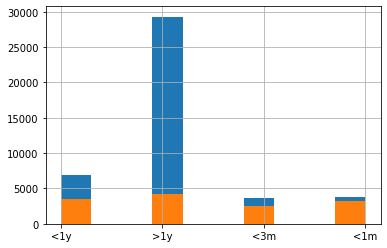

In [331]:
bins = [0, 30, 90, 365, float('inf')]
death_labels = ["<1m", "<3m", "<1y", ">1y"]
d["death_group"] = pd.cut(d.time_to_death, bins=bins, labels=death_labels)
d.death_group.hist()
d[d.rem_cd.isin([8, 13])].death_group.hist()

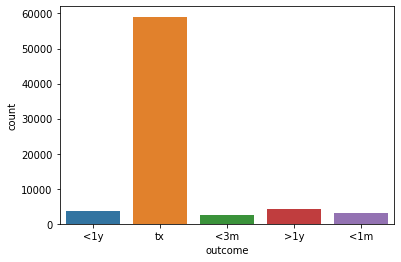

In [332]:
d["outcome"] = d.apply(
    lambda row: 
        "tx" if row.rem_cd == 4 # transplant
        else row.death_group, axis=1) # death in different time intervals
labels = ["tx", "<1m", "<3m", "<1y", ">1y"]

# print distribution plot of outcomes
sns.countplot(x="outcome", data=d)
plt.show()

In [333]:
# print percentage of each outcome
print(d.outcome.value_counts(normalize=True, dropna=False))

tx    0.77879
>1y   0.05517
<1y   0.04715
NaN   0.04440
<1m   0.04220
<3m   0.03230
Name: outcome, dtype: float64


In [334]:
# drop NA outcomes
d.dropna(subset=["outcome"], inplace=True)

In [335]:
all_selected = selected_vars + ["outcome"]
d = d[all_selected]
selset = set(selected_vars)
numerical_columns = list(set(numerical_columns) & selset)
categorical_columns = list(set(categorical_columns) & selset)
date_columns = list(set(date_columns) & selset)
drug_columns = list(set(drug_columns) & selset)

print("Number numeric columns:", len(numerical_columns))
print("Number categorical columns:", len(categorical_columns))
print("Number date columns:", len(date_columns))
print("Number drug columns:", len(drug_columns))

Number numeric columns: 8
Number categorical columns: 26
Number date columns: 0
Number drug columns: 0


# Imputation

Let's add "missing value" columns.

In [336]:
# add missing indicator to numerical columns with missing values
for col in numerical_columns:
    if d[col].isna().any():
        d[col + "_missing"] = d[col].isna().astype(int)

In [337]:
d.head()

,thoracic_dgn,tah,vas,onvent,icu,inotropic,gender,abo,wgt_kg_tcr,hgt_cm_tcr,education,ecmo_tcr,iabp_tcr,inotropes_tcr,func_stat_tcr,diab,dial_ty_tcr,cereb_vasc,malig_tcr,most_rcnt_creat,tot_serum_album,hemo_co_tcr,cig_use,prior_card_surg_tcr,init_stat,init_age,ethnicity,init_hgt_cm_calc,init_wgt_kg_calc,ventilator_tcr,lvad_at_listing,rvad_at_listing,work_income_tcr,academic_level_tcr,outcome,most_rcnt_creat_missing,hgt_cm_tcr_missing,init_age_missing,hemo_co_tcr_missing,init_wgt_kg_calc_missing,tot_serum_album_missing,init_hgt_cm_calc_missing,wgt_kg_tcr_missing
27162,1999,N,N,N,N,NaN,M,O,88.00000,183.00000,NaN,0,0,0,996.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,2030.00000,46.00000,0,183.00000,88.00000,0,NaN,NaN,NaN,996.00000,<1y,1,0,0,1,0,1,0,0
19096,1200,N,N,N,N,N,M,O,90.72000,183.00000,5.00000,0,0,0,2.00000,5.00000,1.00000,N,Y,NaN,NaN,3.40000,NaN,U,2030.00000,35.00000,0,183.00000,90.72000,0,NaN,NaN,NaN,NaN,<1y,1,0,0,0,0,1,0,0
119608,1000,NaN,NaN,NaN,NaN,NaN,F,B,79.37870,160.02000,3.00000,0,0,0,2.00000,1.00000,1.00000,N,N,1.00000,4.70000,4.50000,NaN,U,2030.00000,50.00000,0,160.02000,79.37870,0,NaN,NaN,NaN,NaN,tx,0,0,0,0,0,0,0,0
58780,1000,NaN,NaN,NaN,NaN,NaN,M,A,124.73800,190.50000,4.00000,0,0,1,996.00000,5.00000,1.00000,N,N,1.10000,3.80000,7.00000,NaN,U,2010.00000,51.00000,0,190.50000,124.73800,0,NaN,NaN,NaN,NaN,tx,0,0,0,0,0,0,0,0
75972,1200,N,N,N,N,NaN,M,B,59.00000,168.00000,NaN,0,0,0,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,U,2030.00000,62.00000,0,168.00000,59.00000,0,NaN,NaN,NaN,NaN,tx,1,0,0,1,0,1,0,0


Finally, let's impute the missing values.

In [338]:
# impute numerical columns with the mean
d[numerical_columns] = d[numerical_columns].fillna(d[numerical_columns].mean())
# TODO: impute with randomness

# Normalization and encoding

Now, let's normalize numerical values.

In [339]:
from sklearn.preprocessing import StandardScaler

# standardize numerical columns
scaler = StandardScaler()
d[numerical_columns] = scaler.fit_transform(d[numerical_columns])

Let's also encode categorical columns using One-Hot encoding.

In [340]:
d = pd.get_dummies(d, columns=categorical_columns, drop_first=False)

In [341]:
print("Number columns after one-hot encoding:", len(d.columns))

Number columns after one-hot encoding: 166


# Model training

Useful functions:

In [342]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def print_evaluation(y_test, y_pred, labels=None):
    print(classification_report(y_test, y_pred, labels=labels))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.show()

def print_training_history(history):
    history_dict = history.history
    loss_values = history_dict["loss"]
    val_loss_values = history_dict["val_loss"]
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, "bo", label="Training loss")
    plt.plot(epochs, val_loss_values, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    acc = history_dict["accuracy"]
    val_acc = history_dict["val_accuracy"]
    plt.plot(epochs, acc, "bo", label="Training acc")
    plt.plot(epochs, val_acc, "b", label="Validation acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)

In [346]:
# split data into train and test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
outcome = le.fit_transform(d.outcome)

X_train, X_test, y_train, y_test = train_test_split(d.drop("outcome", axis=1), d.outcome, test_size=0.2, random_state=1337)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

y_train_d = pd.get_dummies(y_train)
y_val_d = pd.get_dummies(y_val)
y_test_d = pd.get_dummies(y_test)

## Simple Logistic Regression Model

              precision    recall  f1-score   support

          tx       0.89      0.99      0.94     11781
         <1m       0.41      0.23      0.29       639
         <3m       0.31      0.03      0.06       495
         <1y       0.30      0.11      0.16       743
         >1y       0.49      0.37      0.42       841

    accuracy                           0.85     14499
   macro avg       0.48      0.35      0.37     14499
weighted avg       0.79      0.85      0.81     14499



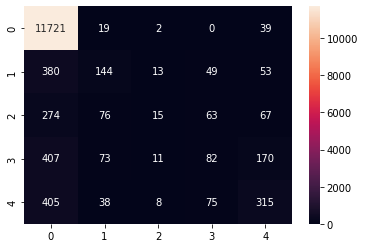

In [360]:
# Simple logistic regression model test
from sklearn.linear_model import LogisticRegression

# train model
model = LogisticRegression(solver="lbfgs", max_iter=1000, n_jobs=-1)
model.fit(pd.concat([X_train, X_val]), pd.concat([y_train, y_val]))

y_pred = model.predict(X_test)

print_evaluation(y_test, y_pred, labels=labels)

In [361]:
# print weights ordered by scale
weights = pd.DataFrame({"feature": X_train.columns, "weight": model.coef_[0]})
weights["abs_weight"] = weights.weight.abs()
weights = weights.sort_values("abs_weight", ascending=False)
print(weights)

                      feature   weight  abs_weight
37          work_income_tcr_Y -1.88796     1.88796
35          work_income_tcr_N -1.72883     1.72883
36          work_income_tcr_U -1.36946     1.36946
89       func_stat_tcr_2080.0 -1.21224     1.21224
65   academic_level_tcr_998.0 -1.13546     1.13546
38                  cig_use_N  1.01668     1.01668
90       func_stat_tcr_2090.0 -0.99247     0.99247
61     academic_level_tcr_1.0 -0.93220     0.93220
91       func_stat_tcr_2100.0 -0.92887     0.92887
39                  cig_use_Y  0.91709     0.91709
87       func_stat_tcr_2060.0 -0.90616     0.90616
27                inotropic_N -0.90574     0.90574
141         thoracic_dgn_1552  0.85448     0.85448
63     academic_level_tcr_3.0 -0.84049     0.84049
77          func_stat_tcr_1.0 -0.83383     0.83383
81        func_stat_tcr_998.0 -0.82845     0.82845
20                     abo_A1  0.78228     0.78228
78          func_stat_tcr_2.0 -0.75152     0.75152
134         thoracic_dgn_1497 -

## 1*8 Neural Network

In [362]:
# 1*8 Neural network
from keras.models import Sequential
from keras.layers import Dense

m8 = Sequential([
    Dense(8, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(y_train_d.shape[1], activation="softmax")
])

m8.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# no early stopping, model too simple to overfit
history = m8.fit(X_train, y_train_d, epochs=30, validation_data=(X_val, y_val_d))

Epoch 1/30
1450/1450 [==============================] - 7s 5ms/step - loss: 0.6233 - accuracy: 0.8179 - val_loss: 0.5175 - val_accuracy: 0.8324
Epoch 2/30
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4890 - accuracy: 0.8404 - val_loss: 0.4893 - val_accuracy: 0.8407
Epoch 3/30
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4716 - accuracy: 0.8466 - val_loss: 0.4808 - val_accuracy: 0.8429
Epoch 4/30
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4648 - accuracy: 0.8481 - val_loss: 0.4740 - val_accuracy: 0.8452
Epoch 5/30
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4618 - accuracy: 0.8490 - val_loss: 0.4725 - val_accuracy: 0.8465
Epoch 6/30
1450/1450 [==============================] - 2s 1ms/step - loss: 0.4596 - accuracy: 0.8494 - val_loss: 0.4707 - val_accuracy: 0.8464
Epoch 7/30
1450/1450 [==============================] - 2s 1ms/step - loss: 0.4582 - accuracy: 0.8493 - val_loss: 0.4710 - val_accuracy:

454/454 [==============================] - 1s 1ms/step


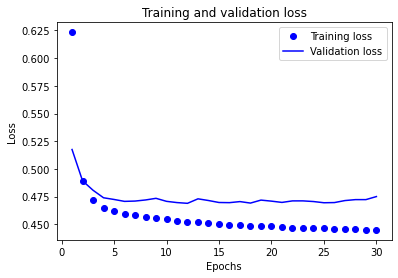

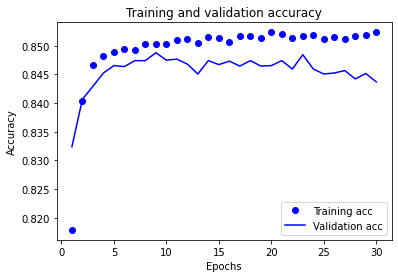

              precision    recall  f1-score   support

          tx       0.89      0.99      0.94     11781
         <1m       0.43      0.23      0.30       639
         <3m       0.21      0.02      0.03       495
         <1y       0.30      0.14      0.19       743
         >1y       0.48      0.37      0.42       841

    accuracy                           0.85     14499
   macro avg       0.46      0.35      0.38     14499
weighted avg       0.79      0.85      0.81     14499



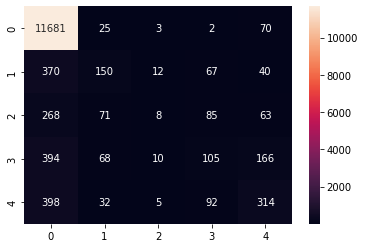

In [363]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m8.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)

## 1*16 Neural Network

In [367]:
# 1*16 neural network
from keras.models import Sequential
from keras.layers import Dense

m16 = Sequential([
    Dense(16, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(y_train_d.shape[1], activation="softmax")
])

m16.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = m16.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1450/1450 [==============================] - 9s 6ms/step - loss: 0.5945 - accuracy: 0.8196 - val_loss: 0.4954 - val_accuracy: 0.8434
Epoch 2/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4725 - accuracy: 0.8470 - val_loss: 0.4793 - val_accuracy: 0.8475
Epoch 3/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4624 - accuracy: 0.8490 - val_loss: 0.4743 - val_accuracy: 0.8481
Epoch 4/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4586 - accuracy: 0.8499 - val_loss: 0.4754 - val_accuracy: 0.8478
Epoch 5/100
1450/1450 [==============================] - 2s 1ms/step - loss: 0.4561 - accuracy: 0.8508 - val_loss: 0.4721 - val_accuracy: 0.8477
Epoch 6/100
1450/1450 [==============================] - 2s 1ms/step - loss: 0.4542 - accuracy: 0.8514 - val_loss: 0.4731 - val_accuracy: 0.8481
Epoch 7/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4521 - accuracy: 0.8517 - val_loss: 0.4700 - val_ac

454/454 [==============================] - 0s 869us/step


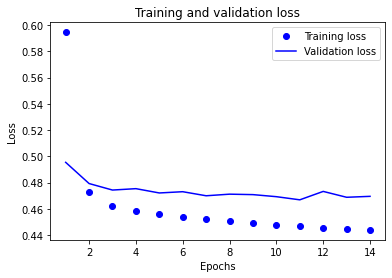

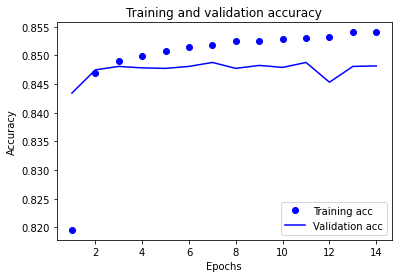

              precision    recall  f1-score   support

          tx       0.89      1.00      0.94     11781
         <1m       0.41      0.23      0.30       639
         <3m       0.28      0.03      0.05       495
         <1y       0.31      0.12      0.17       743
         >1y       0.49      0.34      0.40       841

    accuracy                           0.85     14499
   macro avg       0.47      0.34      0.37     14499
weighted avg       0.79      0.85      0.81     14499



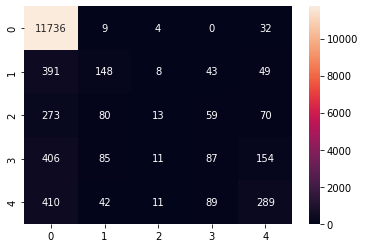

In [368]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m16.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)

## 1*32 Neural Network

In [369]:
# 1*32 neural network
from keras.models import Sequential
from keras.layers import Dense

m32 = Sequential([
    Dense(32, activation="relu", input_shape=(X_train.shape[1],)),
    Dense(y_train_d.shape[1], activation="softmax")
])

m32.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

history = m32.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1450/1450 [==============================] - 7s 4ms/step - loss: 0.5642 - accuracy: 0.8251 - val_loss: 0.4973 - val_accuracy: 0.8421
Epoch 2/100
1450/1450 [==============================] - 2s 1ms/step - loss: 0.4676 - accuracy: 0.8484 - val_loss: 0.4765 - val_accuracy: 0.8452
Epoch 3/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4594 - accuracy: 0.8498 - val_loss: 0.4712 - val_accuracy: 0.8465
Epoch 4/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4539 - accuracy: 0.8515 - val_loss: 0.4690 - val_accuracy: 0.8479
Epoch 5/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4508 - accuracy: 0.8513 - val_loss: 0.4704 - val_accuracy: 0.8480
Epoch 6/100
1450/1450 [==============================] - 2s 2ms/step - loss: 0.4480 - accuracy: 0.8513 - val_loss: 0.4692 - val_accuracy: 0.8477
Epoch 7/100
1450/1450 [==============================] - 2s 1ms/step - loss: 0.4452 - accuracy: 0.8522 - val_loss: 0.4715 - val_ac

454/454 [==============================] - 0s 989us/step


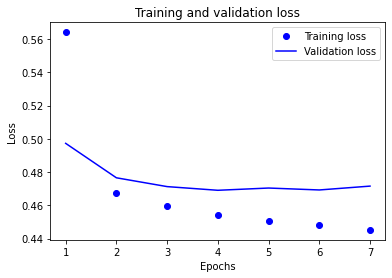

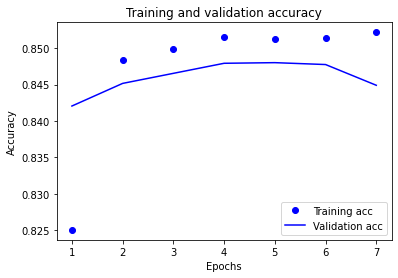

              precision    recall  f1-score   support

          tx       0.89      0.99      0.94     11781
         <1m       0.40      0.26      0.32       639
         <3m       0.38      0.02      0.04       495
         <1y       0.33      0.15      0.21       743
         >1y       0.48      0.40      0.43       841

    accuracy                           0.85     14499
   macro avg       0.50      0.36      0.39     14499
weighted avg       0.80      0.85      0.81     14499



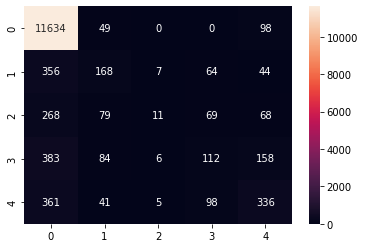

In [370]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m32.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)

## 1*64 Neural Network

In [371]:
# 1*64 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

m64 = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation="relu"),
    Dropout(0.5),
    Dense(y_train_d.shape[1], activation="softmax")
])
m64.compile(loss="categorical_crossentropy", metrics=["accuracy"])

history = m64.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1450/1450 [==============================] - 7s 5ms/step - loss: 0.5932 - accuracy: 0.8242 - val_loss: 0.4951 - val_accuracy: 0.8440
Epoch 2/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.5030 - accuracy: 0.8433 - val_loss: 0.4864 - val_accuracy: 0.8464
Epoch 3/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4960 - accuracy: 0.8452 - val_loss: 0.4910 - val_accuracy: 0.8469
Epoch 4/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4891 - accuracy: 0.8456 - val_loss: 0.4915 - val_accuracy: 0.8475
Epoch 5/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4890 - accuracy: 0.8466 - val_loss: 0.4817 - val_accuracy: 0.8482
Epoch 6/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4836 - accuracy: 0.8477 - val_loss: 0.4846 - val_accuracy: 0.8467
Epoch 7/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4854 - accuracy: 0.8478 - val_loss: 0.4873 - val_ac

454/454 [==============================] - 1s 1ms/step


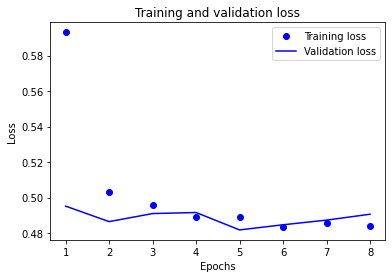

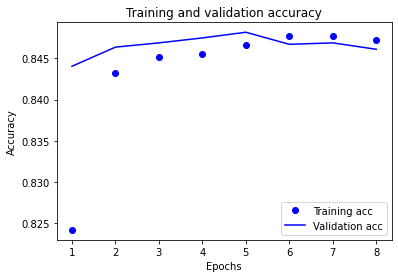

              precision    recall  f1-score   support

          tx       0.89      1.00      0.94     11781
         <1m       0.43      0.17      0.24       639
         <3m       0.25      0.06      0.09       495
         <1y       0.30      0.04      0.07       743
         >1y       0.45      0.40      0.43       841

    accuracy                           0.85     14499
   macro avg       0.46      0.33      0.35     14499
weighted avg       0.79      0.85      0.80     14499



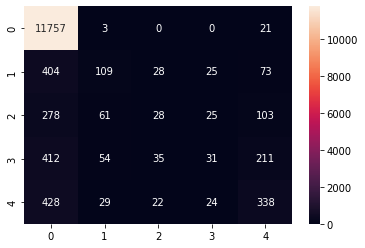

In [372]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m64.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)

## 2 * 4 Neural network

In [373]:
# 2 * 4 neural network
from keras.models import Sequential
from keras.layers import Dense, Dropout

m24 = Sequential([
    Dense(4, input_dim=X_train.shape[1], activation="relu"),
    Dense(4, activation="relu"),
    Dense(y_train_d.shape[1], activation="softmax")
])

m24.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = m24.fit(X_train, y_train_d, epochs=100, validation_data=(X_val, y_val_d), callbacks=[early_stopping_monitor])

Epoch 1/100
1450/1450 [==============================] - 8s 5ms/step - loss: 0.6358 - accuracy: 0.8188 - val_loss: 0.5136 - val_accuracy: 0.8352
Epoch 2/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.5013 - accuracy: 0.8396 - val_loss: 0.4972 - val_accuracy: 0.8375
Epoch 3/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4864 - accuracy: 0.8417 - val_loss: 0.4918 - val_accuracy: 0.8408
Epoch 4/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4734 - accuracy: 0.8452 - val_loss: 0.4789 - val_accuracy: 0.8439
Epoch 5/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4662 - accuracy: 0.8485 - val_loss: 0.4749 - val_accuracy: 0.8445
Epoch 6/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4622 - accuracy: 0.8483 - val_loss: 0.4719 - val_accuracy: 0.8465
Epoch 7/100
1450/1450 [==============================] - 3s 2ms/step - loss: 0.4599 - accuracy: 0.8495 - val_loss: 0.4700 - val_ac

454/454 [==============================] - 1s 1ms/step


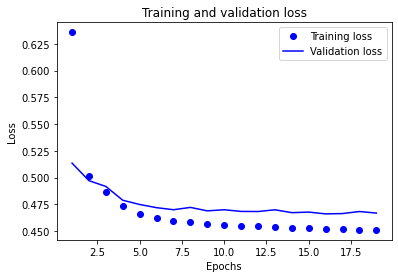

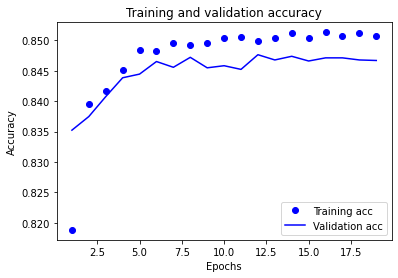

              precision    recall  f1-score   support

          tx       0.89      1.00      0.94     11781
         <1m       0.38      0.24      0.30       639
         <3m       0.19      0.01      0.01       495
         <1y       0.29      0.05      0.09       743
         >1y       0.47      0.40      0.43       841

    accuracy                           0.85     14499
   macro avg       0.44      0.34      0.35     14499
weighted avg       0.79      0.85      0.81     14499



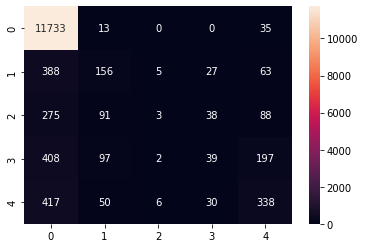

In [374]:
y_pred_class = list(map(lambda x: sorted(labels)[x], np.argmax(m24.predict(X_test), axis=1)))
print_training_history(history)
print_evaluation(y_test, y_pred_class, labels=labels)